In [1]:
!pip install tiktoken

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import tiktoken

In [3]:
tokenizer = tiktoken.get_encoding("gpt2")

## Model Class Components

In [4]:
class LayerNormalization(torch.nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False) # bessel correction n instead of (n -1 )
        norm_x = (x - mean) / torch.sqrt(var + self.eps) # prevent divide by zero
        return norm_x * self.scale + self.shift # two learnable parameters model learns during training

In [5]:
class GeLU(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [6]:
class FeedForward(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["embedding_size"], 4 * cfg["embedding_size"]),
            GeLU(),
            nn.Linear(4 * cfg["embedding_size"], cfg["embedding_size"])
        )

    def forward(self, x):
        return self.layers(x)

In [7]:
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_Query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_Key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_Value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.size() # batch, num_tokens, dimension

        keys = self.W_Key(x)
        queries = self.W_Query(x)
        values = self.W_Value(x)
        # We change last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim) to split the d_out in num_heads part
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        # transpose (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attention_scores = queries @ keys.transpose(-2, -1) # we transpose the last two dimension as the first two will be broadcased

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attention_scores.masked_fill_(mask_bool, float("-inf"))

        attention_weights = torch.nn.functional.softmax(attention_scores / keys.shape[-1] ** 0.5, dim=-1)

        attention_weights = self.dropout(attention_weights)

        context_vectors = (attention_weights @ values).transpose(1, 2) # (b, num_heads, num_tokens, head_dim) -> (b, num_tokens, num_heads, head_dim)

        context_vectors = context_vectors.contiguous().view(b, num_tokens, self.d_out)
        context_vectors = self.out_proj(context_vectors)

        return context_vectors

In [8]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["embedding_size"],
            d_out=cfg["embedding_size"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNormalization(cfg["embedding_size"])
        self.norm2 = LayerNormalization(cfg["embedding_size"])
        self.drop_skip = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        skip = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_skip(x)
        x = x + skip

        skip = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_skip(x)
        x = x + skip

        return x

In [9]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["embedding_size"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["embedding_size"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = LayerNormalization(cfg["embedding_size"])
        self.out_head = nn.Linear(cfg["embedding_size"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits

## Utils Function

In [10]:
def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
  flat = token_ids.squeeze(0)
  return tokenizer.decode(flat.tolist())

In [11]:
with open("./pretrain_roman_nepali.txt", "r", encoding="utf-8") as f:
  text = f.read()

In [12]:
total_characters = len(text)
total_tokens = len(tokenizer.encode(text))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

train_ratio = 0.90
split_idx = int(total_characters * train_ratio)
train_data = text[:split_idx]
val_data = text[split_idx:]

Characters: 961787
Tokens: 333706


## Preparaing Data

In [13]:
from torch.utils.data import Dataset, DataLoader

class DatasetV1(Dataset):
    def __init__(self, text, tokenizer, max_length, stride):
        """create a dataset from the txt"""
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

        for i in range(0, len(token_ids) - max_length, stride): # stride is for overlapping
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i+1:i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
            return len(self.input_ids)

    def __getitem__(self, idx):
            return self.input_ids[idx], self.target_ids[idx]

In [14]:
def create_dataloaderV1(text, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    # initializing tokenizer
    tokenier = tiktoken.get_encoding("gpt2")

    dataset = DatasetV1(text, tokenizer, max_length, stride)

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size, shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [15]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "embedding_size": 128,
    "n_heads": 4,
    "n_layers": 2,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [16]:
torch.manual_seed(123)

train_loader = create_dataloaderV1(
    train_data,
    batch_size=8,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloaderV1(
    val_data,
    batch_size=8,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [80]:
# next(iter(train_loader))

In [17]:
# Sanity check
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [18]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256])

## Evaluation

In [19]:
def calc_loss_batch(input_batch, target_batch, model, device):
  input_batch, target_batch = input_batch.to(device), target_batch.to(device)
  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
  return loss

In [20]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
  total_loss = 0.
  if len(data_loader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))
  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      loss = calc_loss_batch(input_batch, target_batch, model, device)
      total_loss = total_loss + loss.item()
    else:
      break
  return total_loss / num_batches

In [21]:
model = GPTModel(GPT_CONFIG_124M)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

with torch.no_grad():
  # train_loss = calc_loss_loader(train_loader, model, device)
  val_loss = calc_loss_loader(val_loader, model, device)

  # print(f"Train loss: {train_loss:.3f}")
  print(f"Validation loss: {val_loss:.3f}")

Validation loss: 10.995


In [23]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  model.eval()
  with torch.no_grad():
    # train_loss = calc_loss_loader(train_loader, model, device, eval_iter)
    val_loss = calc_loss_loader(val_loader, model, device, eval_iter)
  model.train()
  return val_loss

In [24]:
def generate_text_sample(model, idx, max_new_tokens, context_size):
    """
    Generates a new token in autoregressive manner given a seed token

    Args:
       - model: The GPT Model
       - idx: The seed text token ids
       - max_new_tokens: The maximum number of tokens we want to generate
       - context_size: The number of tokens to consider at one time during inference
    """
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:] # get all batch, and only the last context_size tokens
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :] # get the logits for only the last token which is what we used to predict the next token
        probs = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probs, dim=-1, keepdim=True)
        idx = torch.cat([idx, idx_next], dim=1)

    return idx

In [25]:
def generate_and_print_sample(model, tokenizer, device, start_context):
  model.eval()
  context_size = model.pos_emb.weight.shape[0]
  encoded = text_to_token_ids(start_context, tokenizer).to(device)
  with torch.no_grad():
    token_ids = generate_text_sample(model, encoded, max_new_tokens=50, context_size=context_size)
  decoded_text = token_ids_to_text(token_ids, tokenizer)
  print(decoded_text.replace("\n", " "))
  model.train()

## Training

In [29]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
  train_losses, val_losses, track_tokens_seen = [], [], []
  tokens_seen, global_step = 0, -1

  for epoch in range(num_epochs):
    model.train()

    for input_batch, target_batch in train_loader:
      optimizer.zero_grad()

      loss = calc_loss_batch(input_batch, target_batch, model, device)

      loss.backward()

      optimizer.step()

      tokens_seen += input_batch.numel()

      global_step += 1

      if global_step % eval_freq == 0:
        val_loss = evaluate_model(
            model,
            train_loader,
            val_loader,
            device,
            eval_iter
        )
        train_losses.append(loss.item())
        val_losses.append(val_loss)
        track_tokens_seen.append(tokens_seen)
        print(f"Epoch: {epoch} (Step: {global_step:06d}): Train loss: {loss.item():.3f}, Val loss: {val_loss:.3f}")

    generate_and_print_sample(
        model, tokenizer, device, start_context
    )

  return train_losses, val_losses, track_tokens_seen

In [30]:
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10

train_losses, val_losses, tokens_seen = train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=10,
    eval_iter=10,
    start_context="Every effort moves you",
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Epoch: 0 (Step: 000000): Train loss: 10.981, Val loss: 10.968
Epoch: 0 (Step: 000010): Train loss: 10.645, Val loss: 10.724
Epoch: 0 (Step: 000020): Train loss: 9.812, Val loss: 10.003
Epoch: 0 (Step: 000030): Train loss: 8.939, Val loss: 9.063
Epoch: 0 (Step: 000040): Train loss: 8.017, Val loss: 8.273
Epoch: 0 (Step: 000050): Train loss: 7.190, Val loss: 7.663
Epoch: 0 (Step: 000060): Train loss: 6.853, Val loss: 7.268
Epoch: 0 (Step: 000070): Train loss: 6.443, Val loss: 7.070
Epoch: 0 (Step: 000080): Train loss: 6.241, Val loss: 6.966
Epoch: 0 (Step: 000090): Train loss: 6.288, Val loss: 6.941
Epoch: 0 (Step: 000100): Train loss: 6.211, Val loss: 6.935
Epoch: 0 (Step: 000110): Train loss: 6.143, Val loss: 6.901
Epoch: 0 (Step: 000120): Train loss: 5.876, Val loss: 6.858
Epoch: 0 (Step: 000130): Train loss: 5.817, Val loss: 6.843
Epoch: 0 (Step: 000140): Train loss: 5.940, Val loss: 6.840
Every effort moves you.                                                 
Epoch: 1 (Step: 000150

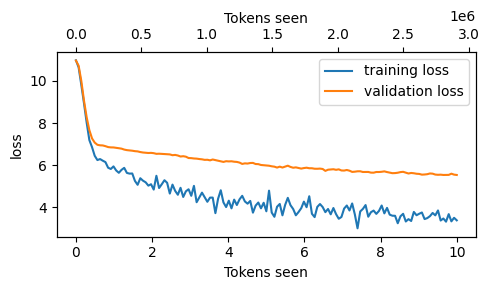

In [31]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
  fig, ax1 = plt.subplots(figsize=(5, 3))

  ax1.plot(epochs_seen, train_losses, label="training loss")
  ax1.plot(epochs_seen, val_losses, label="validation loss")
  ax1.set_xlabel("Tokens seen")
  ax1.set_ylabel("loss")
  ax1.legend()
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

  ax2 = ax1.twiny()
  ax2.plot(tokens_seen, train_losses, alpha=0)
  ax2.set_xlabel("Tokens seen")

  fig.tight_layout()
  plt.savefig("loss-plot.pdf")
  plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [32]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 128)
  (pos_emb): Embedding(256, 128)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_Query): Linear(in_features=128, out_features=128, bias=False)
        (W_Key): Linear(in_features=128, out_features=128, bias=False)
        (W_Value): Linear(in_features=128, out_features=128, bias=False)
        (out_proj): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GeLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
        )
      )
      (norm1): LayerNormalization()
      (norm2): LayerNormalization()
      (drop_skip): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_Query): Linear

In [33]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_sample(model, text_to_token_ids("Nepal", tokenizer), 100, GPT_CONFIG_124M["context_length"])
print(token_ids_to_text(token_ids, tokenizer))

Nepalne cha.



































































































In [34]:
def softmax_with_temperature(logits, temperature):
  scaled_logits = logits / temperature
  return torch.softmax(scaled_logits, dim=0)

## Generate some text

In [35]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)

    logits = logits[:, -1, :]

    if top_k is not None:
      top_logits, _ = torch.topk(logits, top_k)
      # get the minimum value from the logits for all batch here (only one batch)
      min_val = top_logits[:, -1]
      logits = torch.where(logits < min_val, torch.tensor(float("-inf")), logits).to(logits.device)

    if temperature > 0.0:
      logits = logits / temperature

      probs = torch.softmax(logits, dim=-1)

      idx_next = torch.multinomial(probs, num_samples=1)

    else:
      idx_next = torch.argmax(logits, dim=-1, keepdim=True)

    if idx_next == eos_id:
      break

    idx = torch.cat((idx, idx_next), dim=1) # (batch_size, num_tokens + 1)

  return idx

In [42]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Nepali", tokenizer),
    max_new_tokens=100,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text: ", token_ids_to_text(token_ids, tokenizer))

Output text:  Nepali lai manik chahekaarurat pani nas garcha. Aba. Usko cha, hamile tapai kaam garcha timro feedback gai parchha maile yo madadhan. Aba, tyohar kai aba dikhau. Aba jivan, "
Customer: Wah ki tapai ko order le yo dinai, ra delivery samma pani dherai janatva garera jas


In [47]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Hami", tokenizer),
    max_new_tokens=100,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=50,
    temperature=0
)

print("Output text: ", token_ids_to_text(token_ids, tokenizer).replace("\n", " "))

Output text:  Hami sabai ko samasya ko samadhan garne cha.                                                                                      


In [49]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(" ", tokenizer),
    max_new_tokens=100,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=50,
    temperature=0
)

print("Output text: ", token_ids_to_text(token_ids, tokenizer).replace("\n", " "))

Output text:                                                                                                       


In [66]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids("nepal", tokenizer),
    max_new_tokens=100,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=None,
    temperature=0
)

print("Output text: ", token_ids_to_text(token_ids, tokenizer).replace("\n", " "))

Output text:  nepal ko samajik samasya ko samadhan garne cha. Samasya ko samadhan ko samadhan garne ho.                                                                      


In [67]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids("technology", tokenizer),
    max_new_tokens=100,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=None,
    temperature=0
)

print("Output text: ", token_ids_to_text(token_ids, tokenizer).replace("\n", " "))

Output text:  technologyile huncha.    C: Aba ta? CCR: Aba. Aba. Aba. Aba tapai ko lagi tapai ko lagi tapai ko lagi contact garna parcha. Aba. Aba. Aba tapai ko lagi tapai ko lagi tapai ko lagi tapai ko lagi maile delivery ko lagi contact garna sakchhu. Aba. Aba.


In [92]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids("a", tokenizer),
    max_new_tokens=100,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=None,
    temperature=1
)

print("Output text: ", token_ids_to_text(token_ids, tokenizer).replace("\n\n", " "))

Output text:  a gareko cha?
R haru thalyo lagcha.olving living le Maya pani try garna parcha ni banauna saknuhuncha jaha cha.
Anjhe, " insightful din lagi si management kasari rakhne cha.  
CCRina? Mero examples banauna ta education Customer. “Ram ma samasari. Thank ya hosp ko possibilityati ta garna sanga Mathematics ma d


In [93]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(" ", tokenizer),
    max_new_tokens=200,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=100,
    temperature=1
)

print("Output text: ", token_ids_to_text(token_ids, tokenizer).replace("\n\n", " "))

Output text:   
Samma. P� media, yo ma aarthik ra hatvapurna, ra samudaik saksha garcha hami jy ekjut ko yadi ra yeh ko prakritik stath diye ek alagatva le Nepal garna haru dek ko thiyo. Prancha, tara riti ko samajik nai haru ko manchha. Hamro prakritiwarar ek samajako, ra samasya ko lai ekriya sanga ra unko chhaye ma dikhati belaai garera, "Krishna dene le manti, ra samasya ko safalta dima ek kura gariraheko kaam pani garne garna garnecha, jast ko ra Aash sabai samna garne chhnecha. Nepal ko sudai, sam


In [96]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids("nepal", tokenizer),
    max_new_tokens=200,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=100,
    temperature=1
)

print("Output text: ", token_ids_to_text(token_ids, tokenizer).replace("\n\n", " "))

Output text:  nepal jasari, ra sathina, ra usko cha. Paryakda, “
Swasthin ek ramailo garna ko sabai sochheko cha. Aadhanera thi, Ram jaha ra manyo, jo ani garcha. Deshyama parcha ko karan ko upayog garna, andhai manis haru ko mahat ko prayad yehauchne, kshet ma sahoori manuman garna sathai technology ko samajik sanskritikshya le aba. Samajik chhane, tara sakchha, huncha, jeevan ko kasle, jo samarthan ko prashika apno dharmik badhanchata, tara unihar ko prayasik, jivan safarajik rup diyakram ra khana, ra


In [100]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids("hera", tokenizer),
    max_new_tokens=100,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=100,
    temperature=1.3
)

print("Output text: ", token_ids_to_text(token_ids, tokenizer).replace("\n\n", " "))

Output text:  hera.
C: Fullaha tapai ko use information address ch bhine ma email ID aba.** ko lagi update garir. Ek Nepali. Ram CCMayaune ma dhanyabad kahile jindai lati aba bama ekta huna ho ni, seating options chah Hoai milera interest parcha?
Sund, "L din garayo ta order garchaunko ho ta. Jele ke k


In [94]:
tokenizer.encode("sabaijana")

[82, 397, 1872, 73, 2271]

In [95]:
tokenizer.decode([82]),tokenizer.decode([397]), tokenizer.decode([1872])

('s', 'ab', 'ai')